In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import time
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F
import gc
from ptflops import get_model_complexity_info

# Problem 1

In [2]:
train_path = r"C:\Users\ccm51\OneDrive\Desktop\ECGR 4106\fashion-mnist_train.csv"
test_path = r"C:\Users\ccm51\OneDrive\Desktop\ECGR 4106\fashion-mnist_test.csv"
train_numpy = np.loadtxt(train_path, dtype = np.float32, delimiter = ",", skiprows=1)
test_numpy = np.loadtxt(test_path, dtype = np.float32, delimiter = ",", skiprows=1)
print(train_numpy.shape)

(60000, 785)


In [3]:
data_path = '../data-unversioned/ecgr4106/'
fashion_MNIST = datasets.FashionMNIST(data_path, train=True, download=True, transform=ToTensor())
fashion_MNIST_val = datasets.FashionMNIST(data_path, train=False, download=True, transform=ToTensor())

In [123]:
len(fashion_MNIST_val)

10000

In [4]:
def try_gpu(i=0):
    if torch.cuda.device_count() >= i+1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [5]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, update_freq):
    train_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    main_tic = time.perf_counter()
    
    for epoch in range(1, n_epochs + 1):
        tic = time.perf_counter()
        loss_train = 0.0
        correct_train = 0
        correct_val = 0
        
        for imgs, labels in train_loader:
            # if torch.cuda.is_available():
            imgs = imgs.to(device=try_gpu())
            labels = labels.to(device=try_gpu())
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            
        toc = time.perf_counter()
   
        with torch.no_grad():
            total = 0
            for imgs, labels in train_loader:
                outputs = model(imgs.to(device=try_gpu()))
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct_train += int((predicted == labels.to(device=try_gpu())).sum())
            train_acc = round(correct_train/total, 3)
            total = 0
            for imgs, labels in val_loader:
                outputs = model(imgs.to(device=try_gpu()))
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct_val += int((predicted == labels.to(device=try_gpu())).sum())
            val_acc = round(correct_val/total, 3)
        
        train_loss_hist.append(round(loss_train / len(train_loader), 5))
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)
        
        if epoch == 1 or epoch == n_epochs or epoch % update_freq == 0:
            print(f"Epoch {epoch}:\n\tDuration = {round(toc - tic, 3)} seconds\n\tTraining Loss: {train_loss_hist[-1]}\n\tTraining Accuracy: {train_acc_hist[-1]}\n\tValidation Accuracy: {val_acc_hist[-1]}")
            
    main_toc = time.perf_counter()
    print(f"\nTotal Training Time = {round(main_toc - main_tic, 3)} seconds\nAverage Training Time per Epoch = {round((main_toc - main_tic) / n_epochs , 3)} seconds")
    return train_loss_hist, train_acc_hist, val_acc_hist

In [6]:
def plot_model(title, fig_num, loss_hist, train_hist, test_hist, leg_loc):
    plot = plt.figure(fig_num)
    x = range(1, len(loss_hist)+1)
    plt.plot(x, loss_hist)
    plt.plot(x, train_hist)
    plt.plot(x, test_hist)
    plt.legend(["Training Loss", "Training Accuracy", "Testing Accuracy"], loc=leg_loc)
    plt.xlabel('Epoch')
    plt.ylabel('Error/Accuracy')
    plt.title(title)

In [14]:
class alt1_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(6, kernel_size=5, padding=2)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(16, kernel_size=5)
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.LazyLinear(84)
        self.fc3 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.maxp2(self.relu(self.conv2(out)))
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model_1 = alt1_LeNet().to(device=try_gpu())
optimizer_1 = optim.SGD(model_1.parameters(), lr=1e-1)
model_1.eval()

alt1_LeNet(
  (conv1): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [15]:
train_loader_1 = DataLoader(fashion_MNIST, batch_size=128, shuffle=True)
val_loader_1 = DataLoader(fashion_MNIST_val, batch_size=len(fashion_MNIST_val), shuffle=False)

In [16]:
t_loss_hist_1, t_acc_hist_1, v_acc_hist_1 = training_loop(10,
                                                        optimizer_1,
                                                        model_1,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        1)

Epoch 1:
	Duration = 19.818 seconds
	Training Loss: 1.16621
	Training Accuracy: 0.754
	Validation Accuracy: 0.746
Epoch 2:
	Duration = 20.963 seconds
	Training Loss: 0.52571
	Training Accuracy: 0.819
	Validation Accuracy: 0.809
Epoch 3:
	Duration = 19.146 seconds
	Training Loss: 0.42693
	Training Accuracy: 0.86
	Validation Accuracy: 0.851
Epoch 4:
	Duration = 18.765 seconds
	Training Loss: 0.38071
	Training Accuracy: 0.873
	Validation Accuracy: 0.859
Epoch 5:
	Duration = 18.794 seconds
	Training Loss: 0.35066
	Training Accuracy: 0.858
	Validation Accuracy: 0.845
Epoch 6:
	Duration = 18.724 seconds
	Training Loss: 0.32908
	Training Accuracy: 0.89
	Validation Accuracy: 0.875
Epoch 7:
	Duration = 18.646 seconds
	Training Loss: 0.31203
	Training Accuracy: 0.887
	Validation Accuracy: 0.87
Epoch 8:
	Duration = 18.85 seconds
	Training Loss: 0.29782
	Training Accuracy: 0.888
	Validation Accuracy: 0.875
Epoch 9:
	Duration = 18.87 seconds
	Training Loss: 0.28718
	Training Accuracy: 0.9
	Validati

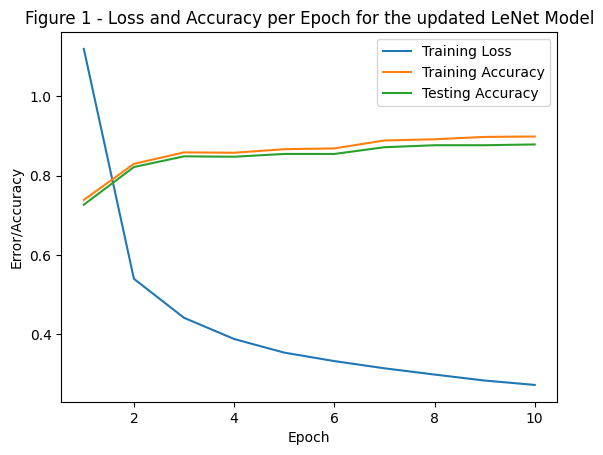

In [162]:
title_1 = "Figure 1 - Loss and Accuracy per Epoch for the updated LeNet Model"
plot_model(title_1, 1, t_loss_hist_1, t_acc_hist_1, v_acc_hist_1, 'upper right')

# Problem 2

In [164]:
class alt2a_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(6, kernel_size=3, padding=1)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(16, kernel_size=3)
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.LazyLinear(84)
        self.fc3 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.maxp2(self.relu(self.conv2(out)))
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model_2a = alt2a_LeNet().to(device=try_gpu())
optimizer_2a = optim.SGD(model_2a.parameters(), lr=1e-1)
model_2a.eval()

alt2a_LeNet(
  (conv1): LazyConv2d(0, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): LazyConv2d(0, 16, kernel_size=(3, 3), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [166]:
t_loss_hist_2a, t_acc_hist_2a, v_acc_hist_2a = training_loop(10,
                                                        optimizer_2a,
                                                        model_2a,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        5)

Epoch 1:
	Duration = 8.57 seconds
	Training Loss: 1.0938
	Training Accuracy: 0.718
	Validation Accuracy: 0.708
Epoch 5:
	Duration = 9.154 seconds
	Training Loss: 0.35228
	Training Accuracy: 0.878
	Validation Accuracy: 0.868
Epoch 10:
	Duration = 8.199 seconds
	Training Loss: 0.27944
	Training Accuracy: 0.901
	Validation Accuracy: 0.886

Total Training Time = 157.307 seconds
Average Training Time per Epoch = 15.731 seconds


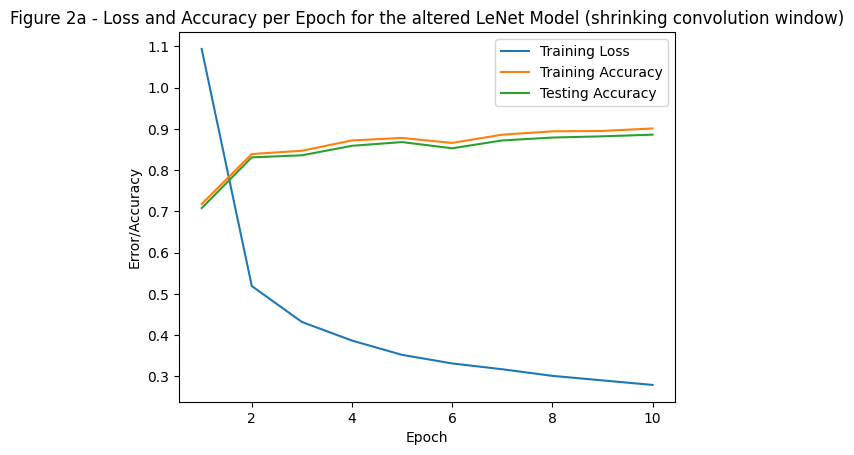

In [167]:
title_2a = "Figure 2a - Loss and Accuracy per Epoch for the altered LeNet Model (Shrinking Convolution Window)"
plot_model(title_2a, 2, t_loss_hist_2a, t_acc_hist_2a, v_acc_hist_2a, 'upper right')

In [168]:
class alt2b_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(6, kernel_size=7, padding=3)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(16, kernel_size=7)
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.LazyLinear(84)
        self.fc3 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.maxp2(self.relu(self.conv2(out)))
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model_2b = alt2b_LeNet().to(device=try_gpu())
optimizer_2b = optim.SGD(model_2b.parameters(), lr=1e-1)
model_2b.eval()

alt2b_LeNet(
  (conv1): LazyConv2d(0, 6, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): LazyConv2d(0, 16, kernel_size=(7, 7), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [169]:
t_loss_hist_2b, t_acc_hist_2b, v_acc_hist_2b = training_loop(10,
                                                        optimizer_2b,
                                                        model_2b,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        5)

Epoch 1:
	Duration = 9.395 seconds
	Training Loss: 1.08711
	Training Accuracy: 0.739
	Validation Accuracy: 0.73
Epoch 5:
	Duration = 9.349 seconds
	Training Loss: 0.34582
	Training Accuracy: 0.875
	Validation Accuracy: 0.86
Epoch 10:
	Duration = 10.162 seconds
	Training Loss: 0.27412
	Training Accuracy: 0.896
	Validation Accuracy: 0.876

Total Training Time = 186.064 seconds
Average Training Time per Epoch = 18.606 seconds


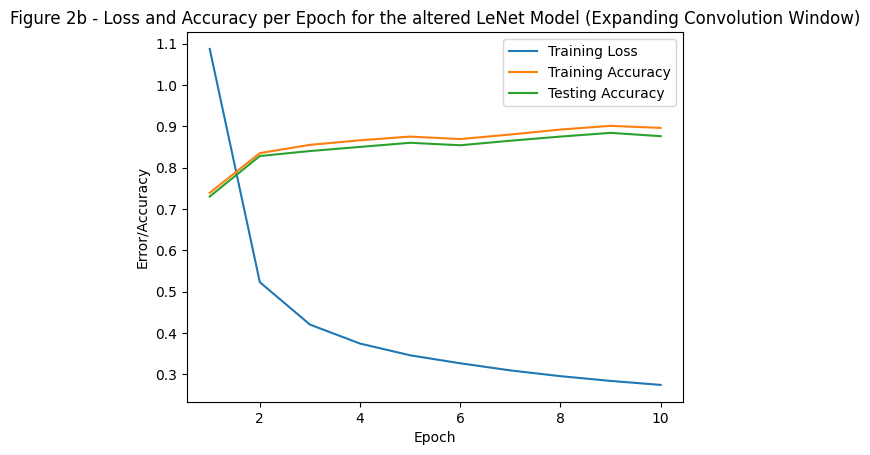

In [170]:
title_2b = "Figure 2b - Loss and Accuracy per Epoch for the altered LeNet Model (Expanding Convolution Window)"
plot_model(title_2b, 3, t_loss_hist_2b, t_acc_hist_2b, v_acc_hist_2b, 'upper right')

In [181]:
class alt3_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(12, kernel_size=5, padding=2)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(32, kernel_size=5)
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.LazyLinear(84)
        self.fc3 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.maxp2(self.relu(self.conv2(out)))
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model_3 = alt3_LeNet().to(device=try_gpu())
optimizer_3 = optim.SGD(model_3.parameters(), lr=1e-1)
model_3.eval()

alt3_LeNet(
  (conv1): LazyConv2d(0, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): LazyConv2d(0, 32, kernel_size=(5, 5), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [182]:
t_loss_hist_3, t_acc_hist_3, v_acc_hist_3 = training_loop(10,
                                                        optimizer_3,
                                                        model_3,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        5)

Epoch 1:
	Duration = 11.009 seconds
	Training Loss: 1.02504
	Training Accuracy: 0.789
	Validation Accuracy: 0.78
Epoch 5:
	Duration = 10.568 seconds
	Training Loss: 0.32999
	Training Accuracy: 0.886
	Validation Accuracy: 0.871
Epoch 10:
	Duration = 11.317 seconds
	Training Loss: 0.24853
	Training Accuracy: 0.915
	Validation Accuracy: 0.896

Total Training Time = 190.937 seconds
Average Training Time per Epoch = 19.094 seconds


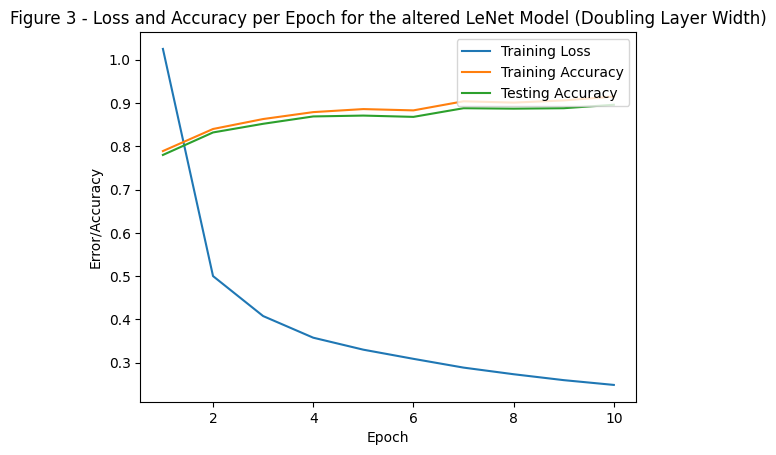

In [183]:
title_3 = "Figure 3 - Loss and Accuracy per Epoch for the altered LeNet Model (Doubling Layer Width)"
plot_model(title_3, 4, t_loss_hist_3, t_acc_hist_3, v_acc_hist_3, 'upper right')

In [196]:
class alt4_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(6, kernel_size=5, padding=2)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(16, kernel_size=5)
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.LazyConv2d(8, kernel_size=5, padding=2)
        self.maxp3 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.LazyLinear(84)
        self.fc3 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.maxp2(self.relu(self.conv2(out)))
        out = self.maxp3(self.relu(self.conv3(out)))
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model_4 = alt4_LeNet().to(device=try_gpu())
optimizer_4 = optim.SGD(model_4.parameters(), lr=1e-1)
model_4.eval()

alt4_LeNet(
  (conv1): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): LazyConv2d(0, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxp3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [197]:
t_loss_hist_4, t_acc_hist_4, v_acc_hist_4 = training_loop(10,
                                                        optimizer_4,
                                                        model_4,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        5)

Epoch 1:
	Duration = 9.411 seconds
	Training Loss: 1.42292
	Training Accuracy: 0.636
	Validation Accuracy: 0.627
Epoch 5:
	Duration = 9.522 seconds
	Training Loss: 0.37345
	Training Accuracy: 0.869
	Validation Accuracy: 0.856
Epoch 10:
	Duration = 9.648 seconds
	Training Loss: 0.29061
	Training Accuracy: 0.896
	Validation Accuracy: 0.876

Total Training Time = 172.741 seconds
Average Training Time per Epoch = 17.274 seconds


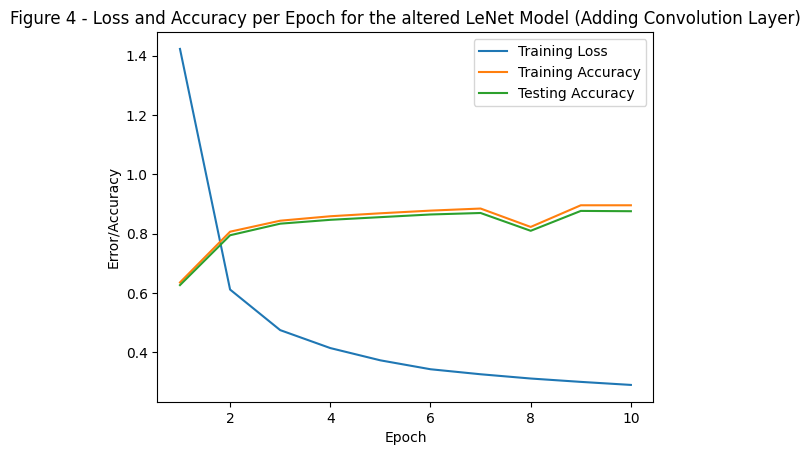

In [198]:
title_4 = "Figure 4 - Loss and Accuracy per Epoch for the altered LeNet Model (Adding Convolution Layer)"
plot_model(title_4, 5, t_loss_hist_4, t_acc_hist_4, v_acc_hist_4, 'upper right')

In [199]:
class alt5_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(6, kernel_size=5, padding=2)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(16, kernel_size=5)
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(256)
        self.fc2 = nn.LazyLinear(120)
        self.fc3 = nn.LazyLinear(84)
        self.fc4 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.maxp2(self.relu(self.conv2(out)))
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out

model_5 = alt5_LeNet().to(device=try_gpu())
optimizer_5 = optim.SGD(model_5.parameters(), lr=1e-1)
model_5.eval()

alt5_LeNet(
  (conv1): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=256, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [200]:
t_loss_hist_5, t_acc_hist_5, v_acc_hist_5 = training_loop(10,
                                                        optimizer_5,
                                                        model_5,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        5)

Epoch 1:
	Duration = 9.023 seconds
	Training Loss: 1.3352
	Training Accuracy: 0.717
	Validation Accuracy: 0.709
Epoch 5:
	Duration = 9.593 seconds
	Training Loss: 0.36617
	Training Accuracy: 0.875
	Validation Accuracy: 0.863
Epoch 10:
	Duration = 11.919 seconds
	Training Loss: 0.27715
	Training Accuracy: 0.899
	Validation Accuracy: 0.882

Total Training Time = 195.642 seconds
Average Training Time per Epoch = 19.564 seconds


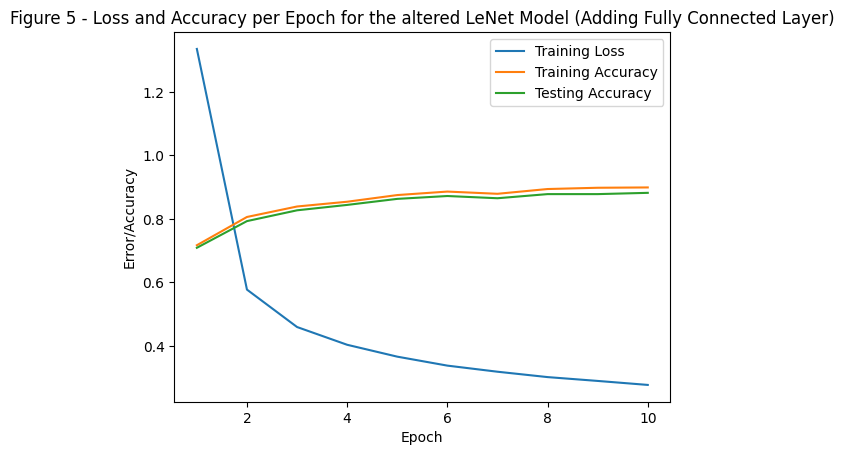

In [201]:
title_5 = "Figure 5 - Loss and Accuracy per Epoch for the altered LeNet Model (Adding Fully Connected Layer)"
plot_model(title_5, 6, t_loss_hist_5, t_acc_hist_5, v_acc_hist_5, 'upper right')

In [204]:
class alt6a_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(6, kernel_size=5, padding=2)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(16, kernel_size=5)
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.LazyLinear(84)
        self.fc3 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.maxp2(self.relu(self.conv2(out)))
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model_6a = alt6a_LeNet().to(device=try_gpu())
optimizer_6a = optim.SGD(model_6a.parameters(), lr=2e-1)
model_6a.eval()

alt6a_LeNet(
  (conv1): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [205]:
t_loss_hist_6a, t_acc_hist_6a, v_acc_hist_6a = training_loop(10,
                                                        optimizer_6a,
                                                        model_6a,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        5)

Epoch 1:
	Duration = 8.659 seconds
	Training Loss: 0.93004
	Training Accuracy: 0.826
	Validation Accuracy: 0.813
Epoch 5:
	Duration = 11.621 seconds
	Training Loss: 0.30714
	Training Accuracy: 0.893
	Validation Accuracy: 0.878
Epoch 10:
	Duration = 10.245 seconds
	Training Loss: 0.23812
	Training Accuracy: 0.918
	Validation Accuracy: 0.891

Total Training Time = 190.071 seconds
Average Training Time per Epoch = 19.007 seconds


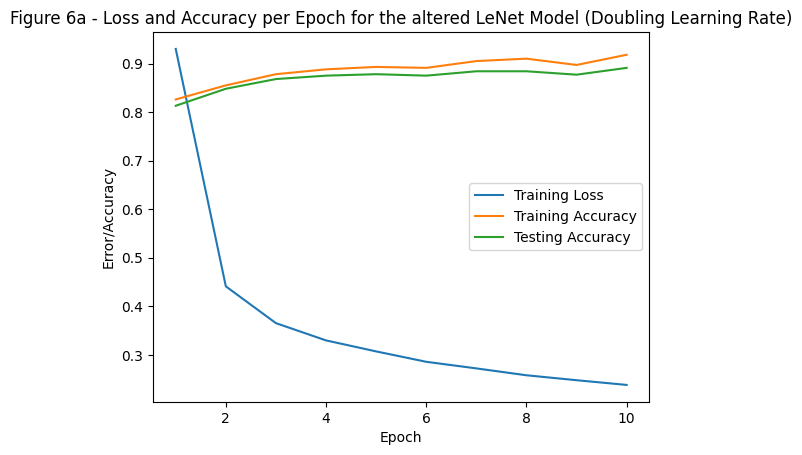

In [289]:
title_6a = "Figure 6a - Loss and Accuracy per Epoch for the altered LeNet Model (Doubling Learning Rate)"
plot_model(title_6a, 7, t_loss_hist_6a, t_acc_hist_6a, v_acc_hist_6a, 'right')

In [207]:
class alt6b_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(6, kernel_size=5, padding=2)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(16, kernel_size=5)
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.LazyLinear(84)
        self.fc3 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.maxp2(self.relu(self.conv2(out)))
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

model_6b = alt6b_LeNet().to(device=try_gpu())
optimizer_6b = optim.SGD(model_6b.parameters(), lr=5e-2)
model_6b.eval()

alt6b_LeNet(
  (conv1): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [208]:
t_loss_hist_6b, t_acc_hist_6b, v_acc_hist_6b = training_loop(10,
                                                        optimizer_6b,
                                                        model_6b,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        5)

Epoch 1:
	Duration = 10.28 seconds
	Training Loss: 1.54733
	Training Accuracy: 0.702
	Validation Accuracy: 0.698
Epoch 5:
	Duration = 8.634 seconds
	Training Loss: 0.41036
	Training Accuracy: 0.858
	Validation Accuracy: 0.847
Epoch 10:
	Duration = 11.12 seconds
	Training Loss: 0.32063
	Training Accuracy: 0.889
	Validation Accuracy: 0.874

Total Training Time = 193.704 seconds
Average Training Time per Epoch = 19.37 seconds


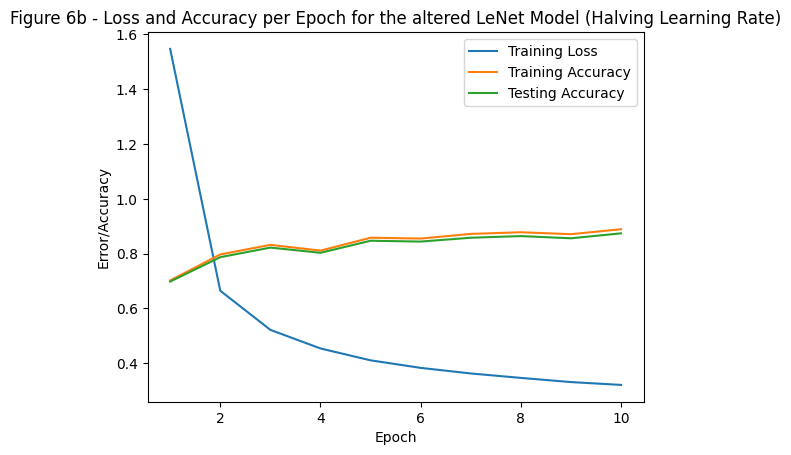

In [209]:
title_6b = "Figure 6b - Loss and Accuracy per Epoch for the altered LeNet Model (Halving Learning Rate)"
plot_model(title_6b, 8, t_loss_hist_6b, t_acc_hist_6b, v_acc_hist_6b, 'upper right')

In [236]:
class alt7_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(10, kernel_size=3, padding=1)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(25, kernel_size=3)
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(200)
        self.fc2 = nn.LazyLinear(120)
        self.fc3 = nn.LazyLinear(84)
        self.fc4 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.maxp2(self.relu(self.conv2(out)))
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out

model_7 = alt7_LeNet().to(device=try_gpu())
optimizer_7 = optim.SGD(model_7.parameters(), lr=2e-1, weight_decay=1e-4)
model_7.eval()

alt7_LeNet(
  (conv1): LazyConv2d(0, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): LazyConv2d(0, 25, kernel_size=(3, 3), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=200, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [237]:
train_loader_2 = DataLoader(fashion_MNIST, batch_size=32, shuffle=True)
val_loader_2 = DataLoader(fashion_MNIST_val, batch_size=int(len(fashion_MNIST_val)/10), shuffle=False)
# Had to reload the loaders with smaller batch sizes because of running low on memory

In [239]:
t_loss_hist_7, t_acc_hist_7, v_acc_hist_7 = training_loop(10,
                                                        optimizer_7,
                                                        model_7,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_2,
                                                        val_loader_2,
                                                        5)

Epoch 1:
	Duration = 13.155 seconds
	Training Loss: 0.67564
	Training Accuracy: 0.86
	Validation Accuracy: 0.854
Epoch 5:
	Duration = 13.621 seconds
	Training Loss: 0.24963
	Training Accuracy: 0.915
	Validation Accuracy: 0.893
Epoch 10:
	Duration = 13.613 seconds
	Training Loss: 0.18169
	Training Accuracy: 0.937
	Validation Accuracy: 0.902

Total Training Time = 224.505 seconds
Average Training Time per Epoch = 22.45 seconds


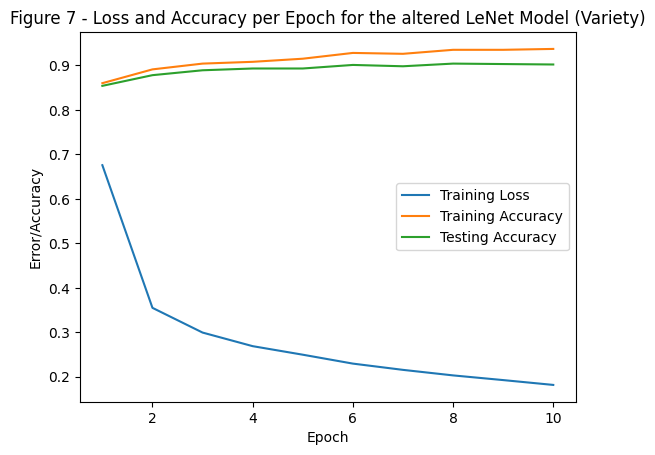

In [240]:
title_7 = "Figure 7 - Loss and Accuracy per Epoch for the altered LeNet Model (Variety)"
plot_model(title_7, 9, t_loss_hist_7, t_acc_hist_7, v_acc_hist_7, 'right')

# Problem 3

In [243]:
class drop_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(10, kernel_size=3, padding=1)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1_drop = nn.Dropout2d(p=0.4)
        self.conv2 = nn.LazyConv2d(25, kernel_size=3)
        self.maxp2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2_drop = nn.Dropout2d(p=0.4)
        self.fc1 = nn.LazyLinear(200)
        self.fc1_drop = nn.Dropout(p=0.3)
        self.fc2 = nn.LazyLinear(120)
        self.fc2_drop = nn.Dropout(p=0.2)
        self.fc3 = nn.LazyLinear(84)
        self.fc4 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.conv1_drop(out)
        out = self.maxp2(self.relu(self.conv2(out)))
        out = self.conv2_drop(out)
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.fc1_drop(out)
        out = self.relu(self.fc2(out))
        out = self.fc2_drop(out)
        out = self.relu(self.fc3(out))
        out = self.fc4(out)
        return out

model_8 = drop_LeNet().to(device=try_gpu())
optimizer_8 = optim.SGD(model_8.parameters(), lr=2e-1, weight_decay=1e-4)
model_8.eval()

drop_LeNet(
  (conv1): LazyConv2d(0, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_drop): Dropout2d(p=0.4, inplace=False)
  (conv2): LazyConv2d(0, 25, kernel_size=(3, 3), stride=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_drop): Dropout2d(p=0.4, inplace=False)
  (fc1): LazyLinear(in_features=0, out_features=200, bias=True)
  (fc1_drop): Dropout(p=0.3, inplace=False)
  (fc2): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc4): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [244]:
t_loss_hist_8, t_acc_hist_8, v_acc_hist_8 = training_loop(10,
                                                        optimizer_8,
                                                        model_8,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_2,
                                                        val_loader_2,
                                                        5)

Epoch 1:
	Duration = 13.207 seconds
	Training Loss: 0.67757
	Training Accuracy: 0.871
	Validation Accuracy: 0.861
Epoch 5:
	Duration = 13.294 seconds
	Training Loss: 0.2448
	Training Accuracy: 0.925
	Validation Accuracy: 0.904
Epoch 10:
	Duration = 14.133 seconds
	Training Loss: 0.18009
	Training Accuracy: 0.934
	Validation Accuracy: 0.897

Total Training Time = 228.715 seconds
Average Training Time per Epoch = 22.871 seconds


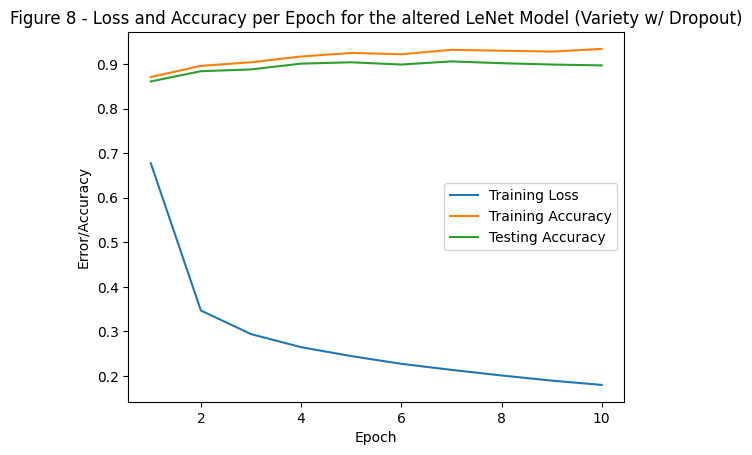

In [246]:
title_8 = "Figure 8 - Loss and Accuracy per Epoch for the altered LeNet Model (Variety w/ Dropout)"
plot_model(title_8, 10, t_loss_hist_8, t_acc_hist_8, v_acc_hist_8, 'right')

# Problem 4

In [279]:
class drop_LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(8, kernel_size=3, stride=2)
        self.maxp1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv1_drop = nn.Dropout2d(p=0.3)
        self.fc1 = nn.LazyLinear(40)
        self.fc2 = nn.LazyLinear(10)
        self.relu = nn.ReLU()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.maxp1(self.relu(self.conv1(x)))
        out = self.conv1_drop(out)
        out = self.flat(out)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

model_9 = drop_LeNet().to(device=try_gpu())
optimizer_9 = optim.SGD(model_9.parameters(), lr=2e-1)
model_9.eval()

drop_LeNet(
  (conv1): LazyConv2d(0, 8, kernel_size=(3, 3), stride=(2, 2))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1_drop): Dropout2d(p=0.3, inplace=False)
  (fc1): LazyLinear(in_features=0, out_features=40, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=10, bias=True)
  (relu): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [280]:
t_loss_hist_9, t_acc_hist_9, v_acc_hist_9 = training_loop(10,
                                                        optimizer_9,
                                                        model_9,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        5)

Epoch 1:
	Duration = 7.261 seconds
	Training Loss: 0.66293
	Training Accuracy: 0.829
	Validation Accuracy: 0.819
Epoch 5:
	Duration = 7.352 seconds
	Training Loss: 0.36155
	Training Accuracy: 0.859
	Validation Accuracy: 0.849
Epoch 10:
	Duration = 7.29 seconds
	Training Loss: 0.31137
	Training Accuracy: 0.872
	Validation Accuracy: 0.85

Total Training Time = 143.395 seconds
Average Training Time per Epoch = 14.34 seconds


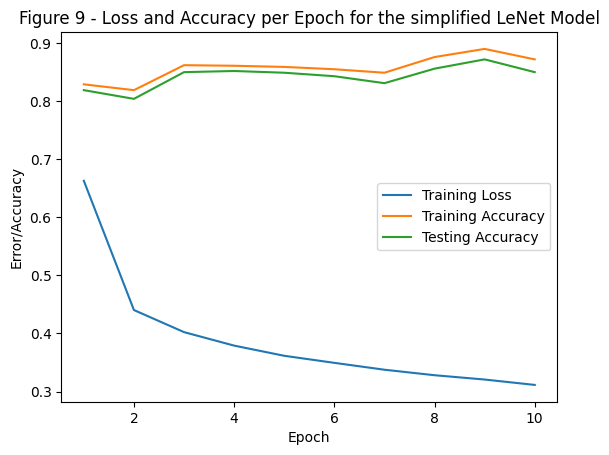

In [281]:
title_9 = "Figure 9 - Loss and Accuracy per Epoch for the simplified LeNet Model"
plot_model(title_9, 11, t_loss_hist_9, t_acc_hist_9, v_acc_hist_9, 'right')

In [288]:
with torch.cuda.device(0):
    macs_LN, params_LN = get_model_complexity_info(model_1, (1, 28, 28), as_strings=True,
                                              print_per_layer_stat=False, verbose=False)
    macs_alt, params_alt = get_model_complexity_info(model_7, (1, 28, 28), as_strings=True,
                                                  print_per_layer_stat=False, verbose=False)
    macs_simp, params_simp = get_model_complexity_info(model_9, (1, 28, 28), as_strings=True,
                                                  print_per_layer_stat=False, verbose=False)
    print('{:<30}  {:<8}'.format('Computational complexity for LeNet: ', macs_LN))
    print('{:<30}  {:<8}'.format('Number of parameters for LeNet: ', params_LN))
    print('\n{:<30}  {:<8}'.format('Computational complexity for Altered LeNet Model: ', macs_alt))
    print('{:<30}  {:<8}'.format('Number of parameters for Altered LeNet Model: ', params_alt))
    print('\n{:<30}  {:<8}'.format('Computational complexity for Simple Model: ', macs_simp))
    print('{:<30}  {:<8}'.format('Number of parameters for Simple Model: ', params_simp))
    

Computational complexity for LeNet:   435.85 KMac
Number of parameters for LeNet:   61.71 k 

Computational complexity for Altered LeNet Model:   644.62 KMac
Number of parameters for Altered LeNet Model:   217.71 k

Computational complexity for Simple Model:   28.23 KMac
Number of parameters for Simple Model:   12.05 k 


In [20]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.LazyConv2d(6, kernel_size=5, padding=2)
        self.avgp1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.LazyConv2d(16, kernel_size=5)
        self.avgp2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.LazyLinear(120)
        self.fc2 = nn.LazyLinear(84)
        self.fc3 = nn.LazyLinear(10)
        self.sgmd = nn.Sigmoid()
        self.flat = nn.Flatten()
        
    def forward(self, x):
        out = self.avgp1(self.sgmd(self.conv1(x)))
        out = self.avgp2(self.sgmd(self.conv2(out)))
        out = self.flat(out)
        out = self.sgmd(self.fc1(out))
        out = self.sgmd(self.fc2(out))
        out = self.fc3(out)
        return out

model_lenet = LeNet().to(device=try_gpu())
optimizer_lenet = optim.SGD(model_lenet.parameters(), lr=1e-1)
model_lenet.eval()

LeNet(
  (conv1): LazyConv2d(0, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (avgp1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): LazyConv2d(0, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgp2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): LazyLinear(in_features=0, out_features=120, bias=True)
  (fc2): LazyLinear(in_features=0, out_features=84, bias=True)
  (fc3): LazyLinear(in_features=0, out_features=10, bias=True)
  (sgmd): Sigmoid()
  (flat): Flatten(start_dim=1, end_dim=-1)
)

In [21]:
t_loss_hist_lenet, t_acc_hist_lenet, v_acc_hist_lenet = training_loop(30,
                                                        optimizer_lenet,
                                                        model_lenet,
                                                        nn.CrossEntropyLoss(),
                                                        train_loader_1,
                                                        val_loader_1,
                                                        5)

Epoch 1:
	Duration = 19.269 seconds
	Training Loss: 2.30714
	Training Accuracy: 0.1
	Validation Accuracy: 0.1
Epoch 5:
	Duration = 18.21 seconds
	Training Loss: 2.3059
	Training Accuracy: 0.1
	Validation Accuracy: 0.1
Epoch 10:
	Duration = 18.659 seconds
	Training Loss: 2.30354
	Training Accuracy: 0.1
	Validation Accuracy: 0.1
Epoch 15:
	Duration = 19.801 seconds
	Training Loss: 1.1266
	Training Accuracy: 0.579
	Validation Accuracy: 0.576
Epoch 20:
	Duration = 17.896 seconds
	Training Loss: 0.79771
	Training Accuracy: 0.71
	Validation Accuracy: 0.704
Epoch 25:
	Duration = 19.274 seconds
	Training Loss: 0.65109
	Training Accuracy: 0.756
	Validation Accuracy: 0.748
Epoch 30:
	Duration = 18.923 seconds
	Training Loss: 0.57976
	Training Accuracy: 0.783
	Validation Accuracy: 0.774

Total Training Time = 1143.003 seconds
Average Training Time per Epoch = 38.1 seconds


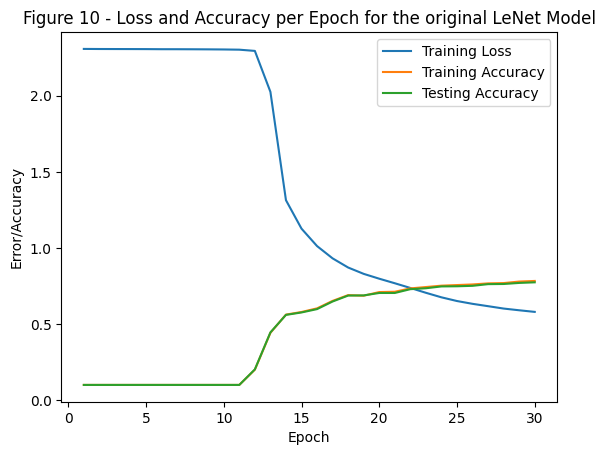

In [23]:
title_10 = "Figure 10 - Loss and Accuracy per Epoch for the original LeNet Model"
plot_model(title_10, 12, t_loss_hist_lenet, t_acc_hist_lenet, v_acc_hist_lenet, 'upper right')